# fitting GP (simplex, multiprocessed)

In [ ]:
from gpFittingFunctions import *

def multiprocessor():
    # Create a multiprocessing pool
    pool = mp.Pool(processes = 20)
    
    # Create a list of arguments for each iteration of the loop
    session_args = ['Raltz', 'Jirachi']
    
    # Execute the loop iterations in parallel
    results_mp = pool.map(process_animal, session_args)
    
    # Close the multiprocessing pool
    pool.close()
    return results_mp
    
if __name__ == "__main__":
    import multiprocessing as mp
    from supplementaryFunctions import *

    results = []
    num_opts = 10
    tic()
    
    # iterator
    for num in range(num_opts):
        results_mp = multiprocessor()
        
        for an, x, fun in results_mp:
            results.append({'animal':an, 'num_opt': num, 'params':x, 'nll':fun})
            print(results[-1])
        
    print('--------------------------------------')
    toc()

{'animal': 'Raltz', 'num_opt': 0, 'params': array([1.54256878e+00, 9.58975824e-01, 1.00000000e-06, 1.00000000e-03,
       1.96270117e-01]), 'nll': 0.0}
{'animal': 'Jirachi', 'num_opt': 0, 'params': array([5.00000000e+00, 1.00000000e-04, 1.41677535e-01, 1.57080740e-01,
       1.00000000e-04]), 'nll': 4809.423059440209}
{'animal': 'Raltz', 'num_opt': 1, 'params': array([1.00000000e-04, 1.00000878e-04, 4.95314467e-01, 4.19296513e+00,
       3.21994228e-01]), 'nll': 5261.889765196647}
{'animal': 'Jirachi', 'num_opt': 1, 'params': array([5.00000000e+00, 1.00000000e-04, 1.41678270e-01, 1.03914622e-01,
       1.34998020e-01]), 'nll': 4809.423059029519}
{'animal': 'Raltz', 'num_opt': 2, 'params': array([2.59189014e+00, 3.00372423e-01, 1.00000000e-06, 1.00000000e-03,
       1.00000000e-04]), 'nll': 0.0}
{'animal': 'Jirachi', 'num_opt': 2, 'params': array([1.00000000e-04, 1.00000000e-04, 1.00000000e+01, 1.00000000e+01,
       8.26936251e-01]), 'nll': 6940.980568975154}
{'animal': 'Raltz', 'num_o

# fitting GP (differential evolution)

In [ ]:
# from opconNosepokeFunctions import *                              # load sessdf
# from gpFittingFunctions import *

# from supplementaryFunctions import *

# load data first
sessdf = pd.read_csv('L:/4portProb_processed/sessdf.csv')
sessdf.drop(columns = 'Unnamed: 0', inplace = True)
window = 7
trialsinsess = 100
exclude = ['[ 20  20  20 100]', '[0 0 0 0]', '[0]', '[0 0]',
       '[1000   80]', '[30]', '[40]', '[70]']
sessdf = sessdf[~sessdf.rewprobfull.isin(exclude)]
sessdf = sessdf[~sessdf.duplicated(subset = ['animal', 'session', 'trialstart', 'eptime'], keep = False)]
sessdf = sessdf.groupby(['animal','session']).filter(lambda x: x.reward.size >= trialsinsess)


In [ ]:
l_an = sessdf.animal.unique()
# tic()
# from scipy.optimize import differential_evolution
lower_bnd, upper_bnd = np.exp(-5), np.exp(5)
bounds = ((lower_bnd, upper_bnd),       # alpha = observation noise variance
          (lower_bnd, 1),               # beta = exploration coefficient
          (lower_bnd, 5),               # tau = for ucb softmax
          (lower_bnd, upper_bnd),      # length scale of the RBF kernel; larger values = more spatial generalization
          (lower_bnd, 1))               # intial q value in a session

result = {}
bin_size = 50
sessdf['sess_bin'] = sessdf.groupby(['animal', 'task'])['session'].transform(lambda x: pd.cut(x, bins=range(0, x.max() + bin_size, bin_size), labels=False, right=False)+1)
n = np.zeros(len(l_an))
for ind, an in enumerate(l_an):
    filtered = sessdf[(sessdf.animal == an) & (sessdf.task == 'unstr') & (sessdf.sess_bin>=4)]
    filtered = filtered.groupby('session').head(trialsinsess)
    args = (filtered, an)
    n[ind] = filtered.shape[0]
    # result[an] = differential_evolution(nLL_gp_ucb,
    #               args=args,
    #               bounds=bounds, disp = True, workers = 8)
    print(an)
# toc()

test05022023
Blissey
Chikorita
Darkrai
Eevee
Goldeen
Hoppip
Inkay
Jirachi
Kirlia
Mesprit
Nidorina
Oddish
Phione
Quilava
Raltz
Shinx
Togepi
Umbreon
Vulpix
Xatu
Yanma
Zacian
Alakazam
Bayleef
Cresselia
Emolga
Giratina
Haxorus
Ivysaur
Jigglypuff
Lugia


In [ ]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
# load file
with open('gp_result.pickle', 'rb') as handle:
    results = pickle.load(handle)
# get params for sim
results_mat = np.zeros((len(results.keys()), 5))
nll = np.zeros(len(results.keys()))

for ind, key in enumerate(results.keys()):
    nll[ind] = results[key].fun
    results_mat[ind] = results[key].x

sns.boxplot(results_mat)
plt.xticks(np.arange(5), ['alpha', 'beta', 'tau', 'ls', 'q_init'])
# plt.title(str(np.mean(results_mat, axis = 0)))
# print(np.round(np.mean(results_mat, axis = 0), 2), np.round(np.median(results_mat, axis = 0), 2))

([<matplotlib.axis.XTick at 0x15b7879fc40>,
 [Text(0, 0, 'alpha'),
  Text(1, 0, 'beta'),
  Text(2, 0, 'tau'),
  Text(3, 0, 'ls'),
  Text(4, 0, 'q_init')])

In [ ]:
bic = 5*np.log(n) + 2*nll
np.mean(bic), np.median(bic)

(np.float64(6622.843631018197), np.float64(5462.170021567466))

In [ ]:
sns.displot(results_mat, discrete = True)

# fitting GPC-UCB

## data loading

In [34]:
import numpy as np
def load_data_into_dict(seed_n = 42):
    import pickle 
    with open('C:/Users/dlab/Downloads/cleandf.pkl', 'rb') as f:
        df = pickle.load(f)

    # subset for expert performance
    subset_df = df[(df.sess_bin>=4) & (df.task == 'unstr')]
    from utils.dfLoading import subset_trials, add_block_groups
    
    # add block groups and select only first block 
    subset_df = add_block_groups(subset_df)
    subset_df = subset_df[subset_df.block_group==1]
    trialsinsess = 100

    # then subset for first 100 trials
    subset_df = subset_trials(subset_df, trialsinsess=trialsinsess, head_trials = trialsinsess)

    np.random.seed(seed_n)

    test_sess_dict = {}
    # pick 10% sessions for testing
    for animal in subset_df.animal.unique():
        unique_sess = subset_df[subset_df.animal == animal].session.nunique()
        test_sess = np.random.choice(subset_df[subset_df.animal == animal].session.unique(), int(unique_sess*0.2), replace = False)
        test_sess_dict[animal] = test_sess
        subset_df.drop(subset_df[(subset_df.animal == animal) & (subset_df.session.isin(test_sess))].index, inplace = True)

    sess_dict = {key: group for key, group in subset_df.groupby('animal')}

    print('loaded data')
    return sess_dict, test_sess_dict

train_data, test_data = load_data_into_dict()

c:\Users\dlab\rishika_sim\utils\dfLoading.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sess_block'] = 0
c:\Users\dlab\rishika_sim\utils\dfLoading.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sess_block'] = df.groupby(['animal', 'task']).sess_block.cumsum()
c:\Users\dlab\rishika_sim\utils\dfLoading.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

loaded data


## manual testing

### sklearn package

In [151]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier     # generate GP 
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel
from utils.supplementaryFunctions import tic, toc
from scipy.special import expit
from scipy.optimize import minimize

# dataset
df = train_data['Lugia']

# session numbers
sessions = df.session.value_counts()
trials = len(df)

# num of choices
arms = 4

# GP settings 
sd_vert = 1   # kernel vert sd
u, temp, ls= [0.      ,   0.0015  ,   0.25976383]
b = 1/temp

# create a kernel
knl = Product(RBF(length_scale=ls), ConstantKernel(constant_value=sd_vert**2))
# knl = RBF(length_scale=ls)
# data info 
chosen_action = df.port.to_numpy()-1
curr_a = chosen_action.reshape(-1, 100)

rewarded = df.reward.to_numpy()
session_ends = np.cumsum(sessions)
sess_num = 0
sess_start = True
mu_star = np.ones(shape = (chosen_action.shape[0], arms))*1e-7
sd_star = np.zeros(shape = (chosen_action.shape[0], arms))

# intialize storage
nll = np.ones(len(df))*1e-7

# for making predictions
X = np.linspace(1,arms,arms).reshape(arms,1)

for trial in range(chosen_action.shape[0]):

    # check if sess restarted
    if sess_start == True:
        gp = GaussianProcessClassifier(kernel = knl, optimizer = None)#, warm_start = True, multi_class='one_vs_one')
        start_trial = trial

    sess_start = False
    
    if len(np.unique(rewarded[start_trial:trial])) > 1:
    # if trial-start_trial>25:
        
        # what actions were taken so far
        a = chosen_action[start_trial:trial]

        # what rewards were given for each action
        r = rewarded[start_trial:trial]
        
        # update gp using all the info we got so far on a and r
        gp.fit(a.reshape(-1, 1), r)

        # get latent mean and variance
        mu, var = gp.latent_mean_and_variance(X)
        mu_star[trial, :] = expit(mu)
        sd_star[trial, :] = expit(np.sqrt(var))

        # create sticky param
        # prev_a = np.zeros(arms)
        # prev_a[int(chosen_action[trial - 1])] = 1 

        # calculate probability of taking any action
        input_to_softmax = (mu_star[trial, :]+u*sd_star[trial, :])*b#+ prev_a*h
        P = np.exp(input_to_softmax - max(input_to_softmax))
        P = P/ np.sum(P)
        P = np.clip(P, a_min = 1e-7, a_max = None)

        # what was probability of action taken?
        chosen = int(chosen_action[trial])
        nll[trial] = P[chosen]

    # check how many trials elapsed
    if trial == session_ends.iloc[sess_num]:
        sess_start=True
        sess_num += 1

nll[nll == 1e-7] = np.nan

nll = -np.log(nll)
nll_mat = nll.reshape(-1, 100)
print(np.nansum(nll))

3577.9480334053414


NR: 317 RR: 662 RN: 385 NN: 441
NR: 180 RR: 85 RN: 168 NN: 223
NR: 84 RR: 16 RN: 35 NN: 101


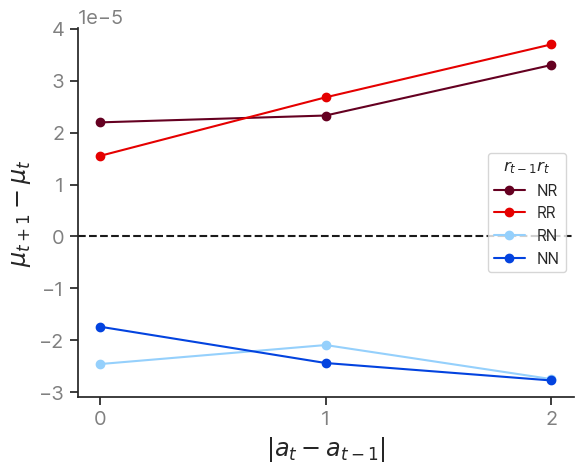

In [152]:
prob_mean = mu_star.reshape(-1, 100, 4)
prob_mean[prob_mean == 1e-7] = np.nan
n_sessions = prob_mean.shape[0]
n_trials = prob_mean.shape[1]

curr_q = prob_mean[np.arange(n_sessions)[:, None], np.arange(n_trials)[None, :], curr_a.astype(int)]
next_mean = np.full_like(prob_mean, np.nan)
next_mean[:, :-1, :] = prob_mean[:, 1:, :]
next_q = next_mean[np.arange(n_sessions)[:, None], np.arange(n_trials)[None, :], curr_a.astype(int)]

curr_a = chosen_action.reshape(-1, 100)
prev_a = np.full_like(curr_a, np.nan)
prev_a[:, 1:] = curr_a[:, :-1]
dist_moved = np.abs(curr_a - prev_a)


curr_r = rewarded.reshape(-1, 100)
prev_r = np.full_like(curr_r, np.nan)
prev_r[:, 1:] = curr_r[:, :-1]

l = []
len_sess = 25
# now compute difference between each of these trials, and condition by distance and by outcome condition
for distance in [0,1,2]:
    mask_NR = (curr_r == 1) & (prev_r == 0) & (dist_moved == distance) #& valid_mask
    mask_RR = (curr_r == 1) & (prev_r == 1) & (dist_moved == distance) #& valid_mask
    mask_RN = (curr_r == 0) & (prev_r == 1) & (dist_moved == distance) #& valid_mask
    mask_NN = (curr_r == 0) & (prev_r == 0) & (dist_moved == distance) #& valid_mask
    l.append(np.nanmean((next_q - curr_q)[:, :len_sess][mask_NR[:, :len_sess]]))
    l.append(np.nanmean((next_q - curr_q)[:, :len_sess][mask_RR[:, :len_sess]]))
    l.append(np.nanmean((next_q - curr_q)[:, :len_sess][mask_RN[:, :len_sess]]))
    l.append(np.nanmean((next_q - curr_q)[:, :len_sess][mask_NN[:, :len_sess]]))
    print("NR:", np.sum(mask_NR[:, :len_sess]), "RR:", np.sum(mask_RR[:, :len_sess]), "RN:", np.sum(mask_RN[:, :len_sess]), "NN:", np.sum(mask_NN[:, :len_sess]))

from utils.plotSettings import *
plt.axhline(0, color = 'k', ls = '--')
plt.plot(l[::4], 'o-', label= 'NR', color = 'xkcd:maroon')
plt.plot(l[1::4], 'o-', label = 'RR', color = 'xkcd:red')
plt.plot(l[2::4], 'o-', label = 'RN', color = 'xkcd:light blue')
plt.plot(l[3::4], 'o-', label = 'NN', color = 'xkcd:blue')

plt.xlabel(r'$|a_{t} - a_{t-1}|$')
plt.xticks(np.arange(3), np.arange(3))
plt.ylabel(r'$\mu_{t+1} - \mu_{t}$')
plt.legend(title = r'$r_{t-1}r_{t}$')

### GPy package

In [171]:
import GPy
import numpy as np
from scipy.special import expit
x0 = [0.      ,   0.0015  ,   0.25976383, 0]
df = train_data['Lugia']

beta, tau, ls, h = x0
arms = 4
ll = 0
# sessions = df.session.value_counts()
chosen_action = df.port.to_numpy().reshape(-1, 100)
rewarded = df.reward.to_numpy().reshape(-1, 100)
p = np.ones_like(chosen_action)*1e-7
P = np.ones(shape = (sessions.shape[0], 100, arms))
mu_star = np.zeros_like(P)
sd_star = np.ones_like(P)

# gp settings
X_new = np.linspace(1,arms,arms).reshape(arms,1)
knl = GPy.kern.RBF(input_dim=1, lengthscale=ls)
# knl = GPy.kern.Prod(kernels = (GPy.kern.RBF(input_dim=1, lengthscale=ls), GPy.kern.Exponential(input_dim=1, lengthscale=10)))


likelihood = GPy.likelihoods.Bernoulli()
laplace_inf = GPy.inference.latent_function_inference.Laplace()

passed = 0
for sess in range(chosen_action.shape[0]):
    for trial in range(chosen_action.shape[1]):
        if trial>0:
            # what actions were taken so far
            a = chosen_action[sess, 0:trial]

            # what rewards were given for each action
            r = rewarded[sess, 0:trial]
            print(a, r)
            if (np.unique(a).shape[0]==1) & (np.unique(r).shape[0]==2):
                passed+=1
                continue
                
            else:
                # gp using all the info we got so far on actions and rew
                m = GPy.models.gp_classification.GPClassification(X = a.reshape(-1, 1),
                                                                    Y = r.reshape(-1, 1),
                                                                    kernel = knl,
                                                                    likelihood = likelihood,
                                                                    inference_method = laplace_inf)

                # get latent mean and variance
                mu, var = m.predict_noiseless(X_new)
                # mu_star[sess, trial, :] = expit(mu)
                # sd_star[sess, trial, :] = expit(np.sqrt(var))
                    
                # # add sticky param
                # prev_a = np.zeros(arms)
                # prev_a[int(chosen_action[trial - 1]) - 1] = 1

                # # calculate probability of taking any action
                # input_to_softmax = (mu_star + beta*sd_star)/tau + prev_a*h
                # P[sess, trial, :] = np.exp(input_to_softmax-max(input_to_softmax))
                # P[sess, trial, :] = P[sess, trial, :]/ np.sum(P[sess, trial, :])
                # P[sess, trial, :] = np.clip(P[sess, trial, :], a_min = 1e-7, a_max = None)

                # # what was probability of action taken?
                # chosen = int(chosen_action[trial] - 1)
                # p[trial] = P[chosen]
        #         else: print('escaped', sess_num)
            print(passed)
# ll += np.sum(np.log(p))
# nll = -ll

[3.] [0.]
0
[3. 4.] [0. 1.]
0
[3. 4. 3.] [0. 1. 0.]
0
[3. 4. 3. 3.] [0. 1. 0. 0.]
0
[3. 4. 3. 3. 4.] [0. 1. 0. 0. 0.]
0
[3. 4. 3. 3. 4. 3.] [0. 1. 0. 0. 0. 1.]
0
[3. 4. 3. 3. 4. 3. 4.] [0. 1. 0. 0. 0. 1. 0.]
0
[3. 4. 3. 3. 4. 3. 4. 4.] [0. 1. 0. 0. 0. 1. 0. 0.]
0
[3. 4. 3. 3. 4. 3. 4. 4. 4.] [0. 1. 0. 0. 0. 1. 0. 0. 0.]
0
[3. 4. 3. 3. 4. 3. 4. 4. 4. 4.] [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
0
[3. 4. 3. 3. 4. 3. 4. 4. 4. 4. 4.] [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
0
[3. 4. 3. 3. 4. 3. 4. 4. 4. 4. 4. 2.] [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
0
[3. 4. 3. 3. 4. 3. 4. 4. 4. 4. 4. 2. 4.] [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
0
[3. 4. 3. 3. 4. 3. 4. 4. 4. 4. 4. 2. 4. 2.] [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
0
[3. 4. 3. 3. 4. 3. 4. 4. 4. 4. 4. 2. 4. 2. 2.] [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
0
[3. 4. 3. 3. 4. 3. 4. 4. 4. 4. 4. 2. 4. 2. 2. 3.] [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
0
[3. 4. 3. 3. 4. 3. 4. 4. 4. 4. 4. 2. 4. 2. 2. 3. 2.] [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1

BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

In [ ]:
x = np.random.choice(np.arange(1,5), size = 10).reshape(-1,1)
y = np.random.choice(2, size = 10).reshape(-1,1)
df = train_data['Hoppip']
chosen_action = df.port.to_numpy().reshape(-1, 100)
rewarded = df.reward.to_numpy().reshape(-1, 100)
x = chosen_action[0, :].reshape(-1,1)
y = rewarded[0, :].reshape(-1,1)
x_new = np.array([1,2,3,4]).reshape(-1,1).astype(float)
# x = np.array([1, 1]).reshape(-1,1)
# y = np.array([0, 1]).reshape(-1,1)
# print(x)
# print(y)
GPy.models.gp_classification.GPClassification(X = x, Y = y, kernel = knl, likelihood = likelihood, inference_method= laplace_inf)

gp_classification.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.25976383,+ve,


### gpflow package 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gpflow
x = np.random.choice(np.arange(1,5), size = 10).reshape(-1,1)
y = np.random.choice(2, size = 10).reshape(-1,1)
model = gpflow.models.VGP(
    (x, y),
    kernel=gpflow.kernels.SquaredExponential(),
    likelihood=gpflow.likelihoods.Bernoulli(),
)

c:\Users\dlab\miniforge3\envs\gpflow\lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [41]:
# x = np.array([1, 1]).reshape(-1,1).astype(float)
# y = np.array([0, 1]).reshape(-1,1)
df = train_data['Hoppip']
chosen_action = df.port.to_numpy().reshape(-1, 100)
rewarded = df.reward.to_numpy().reshape(-1, 100)
x = chosen_action[0, :].reshape(-1,1)
y = rewarded[0, :].reshape(-1,1)
x_new = np.array([1,2,3,4]).reshape(-1,1).astype(float)
# print(x, y, x_new)
model = gpflow.models.VGP(
    (x, y),
    kernel=gpflow.kernels.SquaredExponential(),
    likelihood=gpflow.likelihoods.Bernoulli(),
)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)
model.predict_f(Xnew = x_new, full_cov=True)

(<tf.Tensor: shape=(4, 1), dtype=float64, numpy=
 array([[ 0.46015082],
        [ 1.5957418 ],
        [ 1.77763244],
        [-0.05955124]])>,
 <tf.Tensor: shape=(1, 4, 4), dtype=float64, numpy=
 array([[[ 2.15932293e+00,  7.88496047e-01, -2.13904585e-02,
           2.39760107e-05],
         [ 7.88496047e-01,  1.27059572e+00,  2.53923591e-01,
          -1.77160514e-03],
         [-2.13904585e-02,  2.53923591e-01,  5.51987896e-01,
           3.01943005e-03],
         [ 2.39760107e-05, -1.77160514e-03,  3.01943005e-03,
           1.68627052e-02]]])>)

## run optimization bads/simplex

In [11]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier     # generate GP 
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel
from utils.supplementaryFunctions import tic, toc
from scipy.special import expit
from scipy.optimize import minimize
def nLL_gp_ucb_curr(x0, df, arms):
    beta, tau, ls, h = x0
    ll = 0
    sessions = df.session.value_counts()
    chosen_action = df.port.to_numpy()
    rewarded = df.reward.to_numpy()
    p = np.ones(len(df))*1e-7
    session_ends = np.cumsum(sessions)
    
    sess_num = 0
    sess_start = True

    # gp settings
    X = np.linspace(1,arms,arms).reshape(arms,1)
    knl = Product(RBF(length_scale=ls), ConstantKernel(constant_value=1**2))

    for trial in range(len(chosen_action)):
        # check if sess restarted
        if sess_start == True:
            # if group.block_group.unique()[0] == 1:
            gp = GaussianProcessClassifier(kernel=knl, optimizer = None)
            start_trial = trial

        sess_start = False
        
        # if len(np.unique(rewarded[start_trial:trial])) > 1:
        if trial-start_trial>10:
            # what actions were taken so far
            a = chosen_action[start_trial:trial]

            # what rewards were given for each action
            r = rewarded[start_trial:trial]

            # update gp using all the info we got so far on actions and rew
            gp.fit(a.reshape(-1, 1), r)

            # get latent mean and variance
            mu, var = gp.latent_mean_and_variance(X)
            mu_star = expit(mu)
            sd_star = expit(mu + np.sqrt(var))
            
            # add sticky param
            prev_a = np.zeros(arms)
            prev_a[int(chosen_action[trial - 1]) - 1] = 1

            # calculate probability of taking any action
            input_to_softmax = (mu_star + beta*sd_star)/tau + prev_a*h
            P = np.exp(input_to_softmax-max(input_to_softmax))
            P = P/ np.sum(P)
            P = np.clip(P, a_min = 1e-7, a_max = None)
    
            # what was probability of action taken?
            chosen = int(chosen_action[trial] - 1)
            p[trial] = P[chosen]

        # check how many trials elapsed
        if trial == session_ends.iloc[sess_num]:
            sess_start=True
            sess_num += 1
    # p = p.reshape(100, -1)
    ll += np.sum(np.log(p))
    nll = -ll
    return nll
p = nLL_gp_ucb_curr([3.05656467e-07, 3.08726347e-01, 4.80623368e-1, 2.28407299e+0], train_data['Kirlia'], 4)

In [ ]:
# reward rate
trials = 100
from scipy.stats import sem
plt.figure()
plt.plot(np.mean(rewarded.reshape(-1, 100), axis = 0), color = 'xkcd:cornflower')
plt.fill_between(np.arange(trials), np.mean(rewarded.reshape(-1, 100)) - sem(rewarded.reshape(-1, 100), axis = 0), np.mean(rewarded.reshape(-1, 100))
                  + sem(rewarded.reshape(-1, 100), axis = 0), alpha = 0.3, color = 'xkcd:cornflower')
# chance_level = np.mean(rp_set)
# plt.axhline(chance_level, linestyle = '--', color = 'k')
plt.xlabel('Trials in session')
plt.ylabel('Reward rate')
plt.tight_layout()

In [ ]:
def softmax(arr, temp):
    P = np.exp(arr*1/temp)
    P = P/sum(P)
    return P

from utils.plotSettings import *
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.plot(np.arange(1, 5), mu[99], 'o-', label = 'mean in latent space')
plt.fill_between(np.arange(1, 5), mu[99]-2*np.sqrt(var[99]), mu[99]+2*np.sqrt(var[99]), alpha = 0.3, label = 'std in latent space')
plt.plot(np.arange(1, 5), softmax(mu[99], temp = tau), 'og-', label = 'mean after softmax')
[plt.text(x+1, i+0.2, str(round(i, 4)), fontdict = {'color': 'g'}) for x, i in enumerate(softmax(mu[99], temp = tau))]
# plt.plot(np.arange(1, 5), gp.predict_proba(X)[:, 1], 'ok-', label = 'gp.predict_proba')
plt.xlabel(r'$X$ (choice)')
plt.ylabel(r'$f(X)$')
plt.title('original latent function')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(1, 5), expit(mu[99]), 'ro-', label = 'mean post 0/1 transform')
[plt.text(x+1, i+0.03, str(round(i, 4)), fontdict = {'color': 'r'}) for x, i in enumerate(expit(mu[99]))]
plt.fill_between(np.arange(1, 5), expit(mu[99]-2*np.sqrt(var[99])), expit(mu[99]+2*np.sqrt(var[99])), alpha = 0.3, label = 'std post transform', color = 'r')
# plt.plot(np.arange(1, 5), softmax(expit(mu[99]), temp = tau), 'og-', label = 'mean after softmax')
# [plt.text(x+1, i+0.03, str(round(i, 4)), fontdict = {'color': 'g'}) for x, i in enumerate(softmax(expit(mu[99]), temp = tau))]
# plt.plot(np.arange(1, 5), gp.predict_proba(X)[:, 1], 'ok-', label = 'gp.predict_proba')
plt.xlabel(r'$X$ (choice)')
plt.ylabel(r'expit($f(X)$)')
plt.legend()
plt.title('transformed into "value" space')
plt.tight_layout()

In [162]:
def nllstickyBayesUCB(x0, df, arms):
    tau, c, h = x0
    alpha0, beta0 = 1, 1
    ll = 0
    sessions = df.session.value_counts()
    chosen_action = df.port.to_numpy()
    rewarded = df.reward.to_numpy()
    p = np.zeros(len(df))
    session_ends = np.cumsum(sessions)
        
    sess_num = 0
    sess_start = True
    for trial in range(len(chosen_action)):
        # check if sess restarted
        if sess_start == True:
            # if group.block_group.unique()[0] == 1:
            alphas = np.ones(arms)*alpha0
            betas = np.ones(arms)*beta0
        sess_start = False

        # draw expectation of each arm being selected (alp/ alp+beta)
        q = alphas/(alphas+betas)
        ucb = np.sqrt((alphas*betas)/(((alphas+betas)**2)*alphas+betas+np.ones(arms)))

        # choose sticky arm
        prev_a = np.zeros(arms)
        prev_a[int(chosen_action[trial - 1])-1] = 1

        # softmax prob of choosing actions
        invtemp=1/tau
        input_to_softmax = invtemp*(q+c*ucb) + prev_a*h
        P = np.exp(input_to_softmax - max(input_to_softmax))
        P = P/ np.sum(P) 

        # which action on this trial
        a = chosen_action[trial]
        chosen = int(a-1)

        # probability of selected action on this trial
        p[trial] = P[chosen]

        # rewarded?
        r = rewarded[trial]

        # increment alphas and betas
        alphas[chosen] += r+alpha0
        betas[chosen] += (1-r)+beta0

        # check how many trials elapsed
        if trial == session_ends.iloc[sess_num]:
            sess_start=True
            sess_num += 1

    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

In [ ]:
# fit using either diff-evo or scipy minimize
animals = ['Kirlia']
# train_data, test_data = load_data_into_dict()
extra_params = 4
n_optim = 1
k = 4 # number of parameters for bic
filepath = 'L:/4portProb_simulations/model_parameters_20250919/gpc_first_block_bfgs'
results = {}

# boundaries for parameters
bounds = ((0, 10),      # beta = exploration coefficient
      (0.0015, 100),    # tau = for ucb softmax
      (0.001, 10),      # length scale of the RBF kernel; larger values = more spatial generalization
       (0, 20))       # vertical scaling of the RBF kernel 

# tic()
from scipy.optimize import minimize
for animal in animals:
    data = train_data[animal]
    n_trials = data.shape[0]

    for n in range(n_optim):
        # run multiple optimizations
        print('Running optimization ' + str(n) + '...')

        optimized_result = minimize(
                                    nLL_gp_ucb_curr, 
                                    x0=[1, 1, 1, 1], 
                                    args = (data, extra_params),
                                    bounds = bounds,
                                    method = 'Nelder-Mead',
                                    options = {'disp':True}
                                    )

        results[animal] = [optimized_result.x, optimized_result.fun, optimized_result.success]
        nll = optimized_result.fun
        bic = k*np.log(n_trials) + 2*nll

#         # open a file and store results
#         with open(f'{filepath}.csv', 'a') as f:
#             f.write(f'{animal},{n},{results[animal][0]},{results[animal][1]},{results[animal][2]},{test_data[animal]},{bic}\n')

# # elapsed time
# with open(f'{filepath}.log', 'a') as f:
#     f.write(toc())

Running optimization 0...


NameError: name 'nLL_gp_ucb_curr' is not defined

In [14]:
animals = ['Kirlia']
options = {}
n_optim = 1
extra_params = 4
from pybads import BADS
for animal in animals:
    data = train_data[animal]
    n_trials = data.shape[0]
    def fun_for_pybads(x):
        return nLL_gp_ucb_curr(x, data, extra_params)

    for n in range(n_optim):
        # run multiple optimizations
        print('Running optimization ' + str(n) + '...')
        options['random_seed'] = n  
        bads = BADS(fun_for_pybads, [1,1,1,1], [0, 0.0015, 0.001, 0], [10, 100, 10, 20], options = options)
        # kept changing bounds so something would atleast work lol
        optimize_result = bads.optimize()
        results[animal] = [optimize_result.x, optimize_result.fval, optimize_result.success]
        nll = optimize_result.fval
        bic = k*np.log(n_trials) + 2*nll

Running optimization 0...
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Variables (index) internally transformed to log coordinates: [[0 1]
 [0 2]]


Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2           23263               1                                 Uncertainty test
     0          10         22162.5               1         Initial mesh            Initial points
     0          11         22146.4               1       Successful poll           Train
     1          20         22146.4             0.5         Refine grid             Train
     2          22         21540.1             0.5     Successful search (ES-wcm)        
     2          25           21327             0.5     Successful search (ES-wcm)        
     2          33         21298.6               1       Successful poll           Train
     3          44         21298.6             0.5         Refine grid             Train
     4          56         21298.6            0.25         Refine grid             Train
     5          59      

NameError: name 'results' is not defined

## testing dataset functions

In [1]:
import GPy
import numpy as np
from scipy.special import expit

def nll_gpy_gpc_ucb(x0, df, arms):
    beta, tau, ls, h = x0
    ll = 0
    sessions = df.session.value_counts()
    chosen_action = df.port.to_numpy()
    rewarded = df.reward.to_numpy()
    p = np.ones(len(df))*1e-7
    session_ends = np.cumsum(sessions)
    
    sess_num = 0
    sess_start = True

    # gp settings
    X_new = np.linspace(1,arms,arms).reshape(arms,1)
    knl = GPy.kern.RBF(ls)
    likelihood = GPy.likelihoods.Bernoulli()
    laplace_inf = GPy.inference.latent_function_inference.Laplace()

    for trial in range(len(chosen_action)):
        # check if sess restarted
        if sess_start == True:
            start_trial = trial

        sess_start = False
        
        if start_trial-trial > 1:
            # what actions were taken so far
            a = chosen_action[start_trial:trial]

            # what rewards were given for each action
            r = rewarded[start_trial:trial]

            # gp using all the info we got so far on actions and rew
            m = GPy.models.gp_classification.GPClassification(X = a.reshape(-1, 1),
                                                              Y = r.reshape(-1, 1),
                                                              kernel = knl,
                                                              likelihood = likelihood,
                                                              inference_method = laplace_inf)

            # get latent mean and variance
            mu, var = m.predict_noiseless(X_new)
            mu_star = expit(mu)
            sd_star = expit(mu + np.sqrt(var))
            
            # add sticky param
            prev_a = np.zeros(arms)
            prev_a[int(chosen_action[trial - 1]) - 1] = 1

            # calculate probability of taking any action
            input_to_softmax = (mu_star + beta*sd_star)/tau + prev_a*h
            P = np.exp(input_to_softmax-max(input_to_softmax))
            P = P/ np.sum(P)
            P = np.clip(P, a_min = 1e-7, a_max = None)
    
            # what was probability of action taken?
            chosen = int(chosen_action[trial] - 1)
            p[trial] = P[chosen]

        # check how many trials elapsed
        if trial == session_ends.iloc[sess_num]:
            sess_start=True
            sess_num += 1

    ll += np.sum(np.log(p))
    nll = -ll
    return nll